In [ ]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML
from astroML.datasets import fetch_LINEAR_sample
from astropy.coordinates import SkyCoord
import astropy.units as u

# Basic libraries
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm

# CONFIGURATION
# -------------
sns.set_theme() # setting the theme for plotting
sys.path.insert(0,'../src/')
np.random.seed(42)

# configuring plotting colors
colors = ['#5F6372', '#79A8A4', '#B2AD8F', '#92A186', '#AD8082']
blue = '#5F6372'
turqoise = '#79A8A4'
light_green = '#B2AD8F'
green = '#92A186'
pink = '#AD8082'
muted_colors = sns.set_palette(sns.color_palette(colors))

# configuring fonts for plotting
font = FontProperties()
font.set_family('avenir')
font.set_name('Big Caslon')
font.set_style('normal')
font.set_size('xx-large')


%matplotlib inline  

In [ ]:
sys.path.insert(0,'../src/')
import blazhko_analysis
import BE_plotting
import helper
import RR_lyrae_params
import data_access

In [ ]:
from scipy import signal
import pywt

In [ ]:
%load_ext autoreload
%autoreload 2

---

In [ ]:
#| code-fold: false
# DATA from previous notebook
end = 'FINAL_FINAL_FULL'
lc_analysis = pd.read_csv('../outputs/LC_ANALYSIS_FINALFINAL_FINAL_FULL.csv')

lc_analysis['MainPeakL'] = pd.to_numeric(lc_analysis['MainPeakL'], errors='coerce').fillna(0)
lc_analysis['BlazhkoPeakL'] = pd.to_numeric(lc_analysis['BlazhkoPeakL'], errors='coerce').fillna(0)
lc_analysis['BlazhkoPeriodL'] = pd.to_numeric(lc_analysis['BlazhkoPeriodL'], errors='coerce').fillna(0)
lc_analysis['BpowerRatioL'] = pd.to_numeric(lc_analysis['BpowerRatioL'], errors='coerce').fillna(0)
lc_analysis['BsignificanceL'] = pd.to_numeric(lc_analysis['BsignificanceL'], errors='coerce').fillna(0)
lc_analysis['MainPeakZ'] = pd.to_numeric(lc_analysis['MainPeakZ'], errors='coerce').fillna(0)
lc_analysis['BlazhkoPeakZ'] = pd.to_numeric(lc_analysis['BlazhkoPeakZ'], errors='coerce').fillna(0)
lc_analysis['BlazhkoPeriodZ'] = pd.to_numeric(lc_analysis['BlazhkoPeriodZ'], errors='coerce').fillna(0)
lc_analysis['BpowerRatioZ'] = pd.to_numeric(lc_analysis['BpowerRatioZ'], errors='coerce').fillna(0)
lc_analysis['BsignificanceZ'] = pd.to_numeric(lc_analysis['BsignificanceZ'], errors='coerce').fillna(0)

lc_analysis['Pratio'] = round(lc_analysis['Pratio'], 4)
lc_analysis['Plinear'] = round(lc_analysis['Plinear'], 6)
lc_analysis['Pztf'] = round(lc_analysis['Pztf'], 6)
lc_analysis['Lampl'] = round(lc_analysis['Lampl'], 2)
lc_analysis['Zampl'] = round(lc_analysis['Zampl'], 2)
lc_analysis['L_chi2dofR'] = round(lc_analysis['L_chi2dofR'], 1)
lc_analysis['Lmean_chi2dofR'] = round(lc_analysis['Lmean_chi2dofR'], 1)
lc_analysis['Zchi2dofR'] = round(lc_analysis['Zchi2dofR'], 1)
lc_analysis['Zmean_chi2dofR'] = round(lc_analysis['Zmean_chi2dofR'], 1)
lc_analysis['L_chi2dof'] = round(lc_analysis['L_chi2dof'], 1)
lc_analysis['Lmean_chi2dof'] = round(lc_analysis['Lmean_chi2dof'], 1)
lc_analysis['Zchi2dof'] = round(lc_analysis['Zchi2dof'], 1)
lc_analysis['Zmean_chi2dof'] = round(lc_analysis['Zmean_chi2dof'], 1)
lc_analysis['Ampl_diff'] = round(abs(lc_analysis['Lampl'] - lc_analysis['Zampl']), 2)
lc_analysis['dP'] = round(abs((lc_analysis['Plinear']-lc_analysis['Pztf'])/lc_analysis['Pmean']),5)
lc_analysis['MainPeakL'] = round(lc_analysis['MainPeakL'], 4)
lc_analysis['BlazhkoPeakL'] =round(lc_analysis['BlazhkoPeakL'], 4)
lc_analysis['BlazhkoPeriodL'] = round(lc_analysis['BlazhkoPeriodL'], 4)
lc_analysis['BpowerRatioL'] = round(lc_analysis['BpowerRatioL'], 4)
lc_analysis['BsignificanceL'] = round(lc_analysis['BsignificanceL'], 4)
lc_analysis['MainPeakZ'] = round(lc_analysis['MainPeakZ'], 4)
lc_analysis['BlazhkoPeakZ'] = round(lc_analysis['BlazhkoPeakZ'], 4)
lc_analysis['BlazhkoPeriodZ'] = round(lc_analysis['BlazhkoPeriodZ'], 4)
lc_analysis['BpowerRatioZ'] = round(lc_analysis['BpowerRatioZ'], 4)
lc_analysis['BsignificanceZ'] = round(lc_analysis['BsignificanceZ'], 4)
lc_analysis['IndicatorType'] = 'NaN'
lc_analysis['ChiType'] = 'NaN'
lc_analysis['BE_score'] = 'NaN'

periodogr = pickle.load(open("../outputs/periodograms_"+end+".pkl", "rb"))
fits = np.load("../outputs/fits_"+end+".npy", allow_pickle=True)
ztf_data = np.load("../outputs/ztf_data_filter"+end+".npy", allow_pickle=True)

In [ ]:
lc_analysis.head()

In [ ]:
plt.figure(figsize=(15,5))
print(periodogr[4][0])
fl = periodogr[4][1][0]
pl = periodogr[4][1][1]
imax = np.argmax(pl)
f1yr = fl[imax] + 1.02/365
plt.plot([f1yr, f1yr], [0,1], lw = 1, ls='-.', c=green)
#plt.plot([f1yr, f1yr], [0,1], lw = 1, ls='-.', c=green)
plt.plot(fl, pl)
plt.show()

In [ ]:
from scipy.stats import hmean

In [ ]:
p2 = pl**3
plt.figure(figsize=(15,5))
plt.plot(fl, pl, c='red')
plt.plot([f1yr, f1yr], [0,1], lw = 1, ls='-.', c='green')
avg1 = np.sqrt(np.mean(p2**2))
plt.plot(fl, p2, c='blue')
plt.axhline(y = avg1, color = 'black', linestyle = '-') 
plt.ylim([-0.1,0.6])
plt.show()

In [ ]:
Npts = np.size(pl)
# index for the main peak
imax = np.argmax(pl)
# 1 year alias frequency (factor 1.02 to push it a bit over the maximum)
f1yr = fl[imax] + 1.02/365
# iDelta is the max. width for folding around the main peak
if (imax < Npts/2):
    iDelta = imax
else:
    iDelta = Npts - imax
# folded versions 
fFolded = fl[imax:imax+1+iDelta]  
pLeft = pl[imax-iDelta:imax+1]  
pRight = pl[imax:imax+1+iDelta]
pFolded = 0*fFolded
for i in range(0, iDelta-1):
    # multiply the two branches to increase SNR 
    pFolded[i] = pLeft[-i-1] * pRight[i] 
plt.plot(fFolded,pRight,c='gray',lw=1)
plt.plot(fFolded, pFolded,c='blue',lw=1)
plt.plot(fFolded,pRight**3,c='magenta',lw=1)
plt.ylim([-0.1,0.4])
avg1 = np.sqrt(np.mean(p2**2))
plt.axhline(y = avg1, color = 'black', linestyle = '-') 
plt.show()

In [ ]:
foundMin = 0
foldedMax = 0 
ifoldedMax = 0
# NB: the first point is the highest by construction (the main peak)
for i in range(1, iDelta):
    if ((foundMin==0)&(pFolded[i] > pFolded[i-1])):
        # the first time we passed through a local minimum
        if (fFolded[i]>f1yr): foundMin = 1
    if foundMin:
        # after the first local minimum, remember the maximum power and its location
        if (pFolded[i] > foldedMax):
            foldedMax = pFolded[i]
            ifoldedMax = i
# done, return useful quantities       
fMainPeak = fl[imax] # location of the main peak
fBlazhkoPeak = fFolded[ifoldedMax] # location of the second strongest peak

pfoldede = pRight**3
avg1 = np.sqrt(np.mean(pfoldede**2))
print(avg1)

pairs = []
for i in range(len(fFolded)):
    pairs.append((fFolded[i], pfoldede[i]))

peaks_y = [x for x in pfoldede if x>avg1]

peaks_x = []
for j in peaks_y:
    for k in pairs:
        if j==k[1]:
            peaks_x.append(k[0])

# removing the maximum

imax_1 = np.argmax(peaks_y)
peaks_x = peaks_x.remove(imax_1)
peaks_y = peaks_y.remove(max(peaks_y))

# removing the one year alias
peaks_x = peaks_x.remove(f1yr)

plt.plot([fBlazhkoPeak,fBlazhkoPeak],[0,0.6],'red',lw=2)
plt.plot([f1yr, f1yr], [0,1], lw = 1, ls='-.', c='green')
plt.plot(fFolded,pFolded,lw=2)
plt.plot(fFolded,pfoldede,c='yellow',lw=0.5)
plt.plot(peaks_x,peaks_y,'.')

plt.axhline(y = avg1, color = 'black', linestyle = '-') 
plt.show()

---

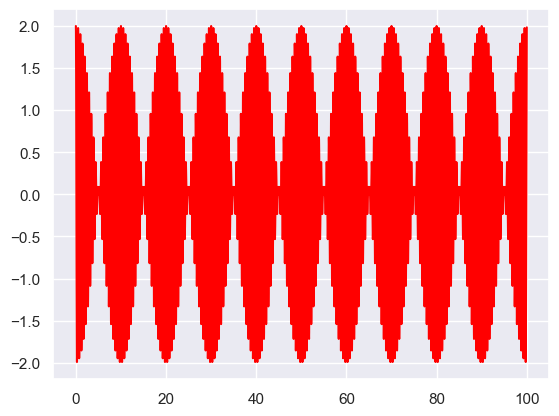

In [20]:
time = np.arange(0,100,0.01)
A = 1
f1 = 2
f2 = 2.1
y1 = A*np.cos(2*np.pi*f1*time)
y2 = A*np.cos(2*np.pi*f2*time)

plt.plot(time, y1+y2, 'red')
plt.show()

---

In [1]:
import numpy as np
# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
from scipy.stats import norm
np.random.seed(42)
import sys
%matplotlib inline  

In [2]:
from astroML.utils.decorators import pickle_results
from astroML.datasets import fetch_LINEAR_sample
from astropy.table import Table
from astropy.timeseries import LombScargle
from astroML.time_series import MultiTermFit

In [3]:
sns.set_theme() # setting the theme for plotting
sys.path.insert(0,'../src/')
np.random.seed(42)
# configuring plotting colors
colors = ['#5F6372', '#79A8A4', '#B2AD8F', '#92A186', '#AD8082']
blue = '#5F6372'
turqoise = '#79A8A4'
light_green = '#B2AD8F'
green = '#92A186'
pink = '#AD8082'
cmap = mcolors.ListedColormap(colors)

# configuring fonts for plotting
font = FontProperties()
font.set_family('avenir')
font.set_name('Big Caslon')
font.set_style('normal')
font.set_size('xx-large')


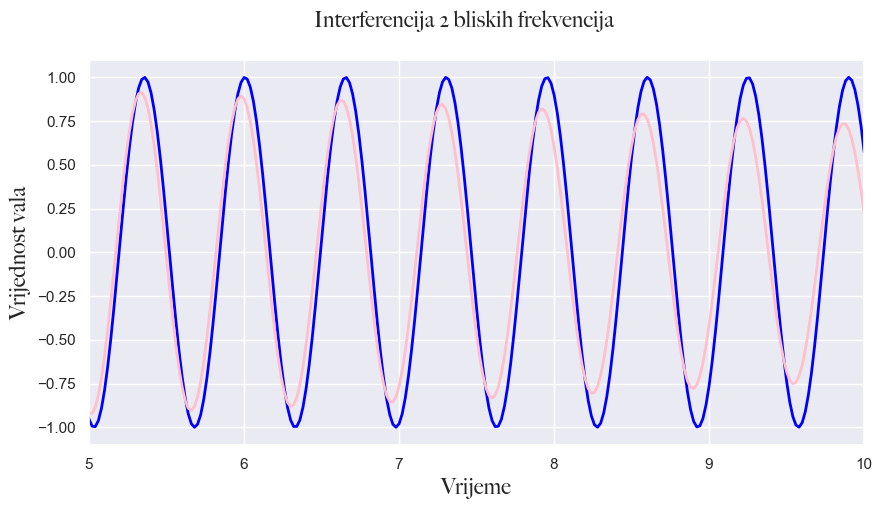

In [91]:
# SIMULATED DATA
Ngrid = 5000  
Tmax = 100     # we generate light curve for times going from 0 to 100 days
maxmagerr = 0.3
# ----
time = np.linspace(0, Tmax, Ngrid)

fn = 1.54 # normal frequency
fblazhko = 1.57 # blazhko frequency
Ablazhko = 0.3 # blazhko amplitude

lcn = np.sin(2*time*fn*3.1415926) # standard light curve data - no modulation 
lc_blazhko = np.sin(2*3.1415926*fblazhko*time)*Ablazhko + lcn # inference beats with the blazhko frequency
lc_blazhko = lc_blazhko/np.max(lc_blazhko) # normalizing to 1 magnitude so scale stays the same

fig = plt.figure(figsize=(10, 5))
fig.suptitle("Interferencija 2 bliskih frekvencija", fontproperties=font,fontsize=16)
plt.plot(time, lcn,c="blue", lw=2)
plt.plot(time,lc_blazhko,c="pink", lw=2)
plt.xlabel("Vrijeme", fontproperties=font,fontsize=16)
plt.ylabel("Vrijednost vala", fontproperties=font,fontsize=16)
plt.xlim(5,10)
plt.savefig("../images/interpolation.png", dpi=650)
plt.show()

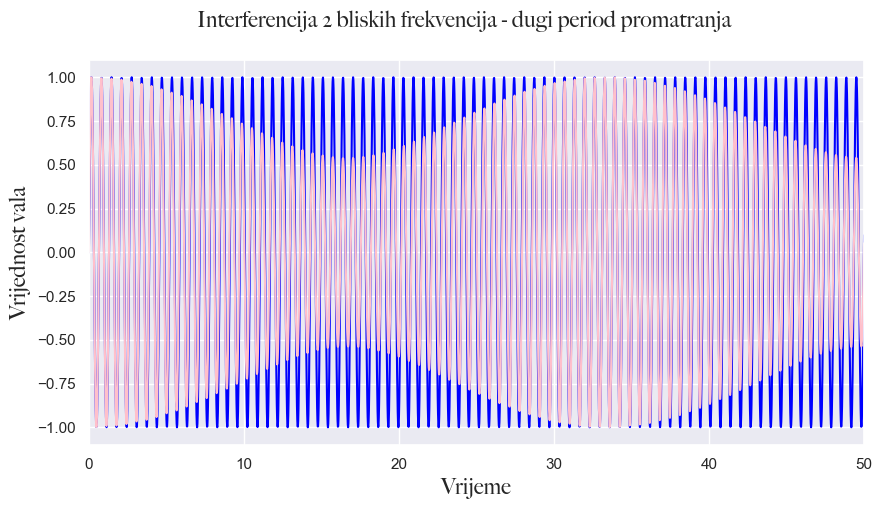

In [92]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle("Interferencija 2 bliskih frekvencija - dugi period promatranja", fontproperties=font,fontsize=16)
plt.plot(time, lcn,c="blue")
plt.plot(time,lc_blazhko,c="pink")
plt.xlabel("Vrijeme", fontproperties=font,fontsize=16)
plt.ylabel("Vrijednost vala", fontproperties=font,fontsize=16)
plt.xlim(0,50)
plt.savefig("../images/interpolation2.png", dpi=650)
plt.show()

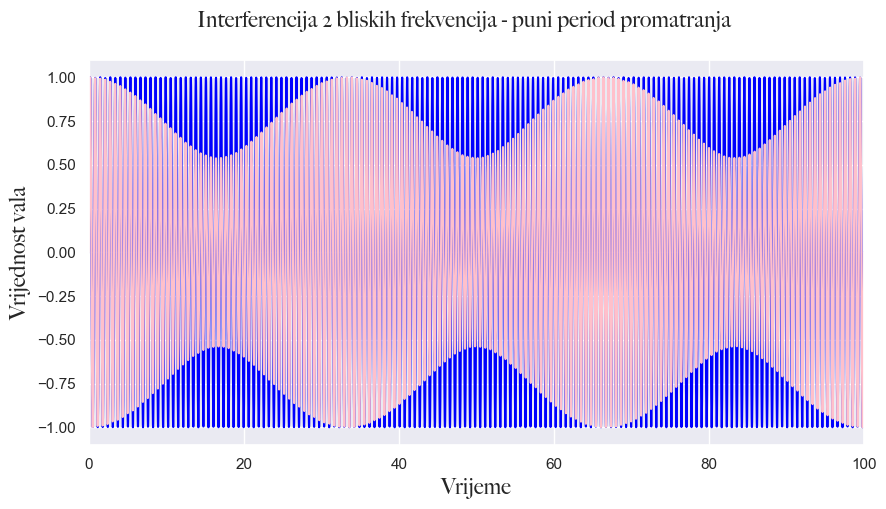

In [93]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle("Interferencija 2 bliskih frekvencija - puni period promatranja", fontproperties=font,fontsize=16)
plt.plot(time, lcn,c="blue")
plt.plot(time,lc_blazhko,c="pink")
plt.xlabel("Vrijeme", fontproperties=font,fontsize=16)
plt.ylabel("Vrijednost vala", fontproperties=font,fontsize=16)
plt.xlim(0,100)
plt.savefig("../images/interpolation3.png", dpi=650)
plt.show()

---

In [55]:
import random

In [66]:
Ngrid = 300  
Tmax = 100     # we generate light curve for times going from 0 to 100 days
maxmagerr = 0.3
# ----
time = np.linspace(0, Tmax, Ngrid)

fn = 1.54 # normal frequency
fblazhko = 1.57 # blazhko frequency
Ablazhko = 0.3 # blazhko amplitude

lcn = np.sin(2*time*fn*3.1415926) # standard light curve data - no modulation 
lc_blazhko = np.sin(2*3.1415926*fblazhko*time)*Ablazhko + lcn # inference beats with the blazhko frequency
lc_blazhko = lc_blazhko/np.max(lc_blazhko) # normalizing to 1 magnitude so scale stays the same

In [67]:
tObs

array([75.82631959,  2.45869165,  2.21235515, 32.36102191, 48.86431904,
       77.04074178, 68.32953766, 44.59027064, 27.36266663, 99.71245002,
       42.61813022, 45.13870243, 16.36238212, 79.48095487, 69.36822258,
       22.07696128,  8.23810456, 68.04993021, 65.45112143, 27.3259527 ,
       95.08635623, 15.10578918, 43.2334801 , 94.36159202, 41.97273169,
       63.85259477, 39.7594398 , 27.42152023, 98.3977648 , 40.93340063,
       89.40992037, 22.99546059, 21.3104704 ,  3.11340829, 65.16668254,
       36.85263437, 86.43582498, 47.32099067, 96.81934279, 18.55255157,
       86.8623168 , 77.65968528, 77.09218446, 84.47832281, 76.10239909,
       62.62203216, 13.12448777,  3.25261795, 92.08478478, 61.66503145,
       79.6537291 , 48.15223515, 11.7308189 , 12.51857922, 68.55652872,
       43.03058949, 20.05247267, 49.15945467,  6.42089371, 58.19714019,
       26.89934044, 79.75591006, 31.03619589, 45.52201491,  1.16205399,
        7.24468878, 39.24935564, 47.99388347, 60.00205481, 29.16

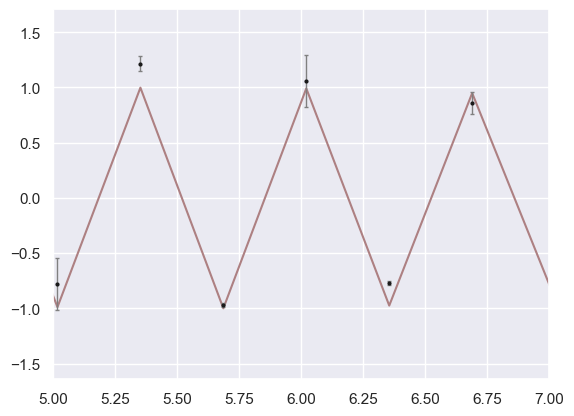

In [68]:
# LIGHT CURVE SIMULATION
# noise for magnitudes, so they aren't all the same
noise = [random.uniform(0-maxmagerr, maxmagerr) for i in range(Ngrid)]
# magnitude error noise
noise2 = [random.uniform(0, maxmagerr) for i in range(Ngrid)]
# creating the more realistic light curve
lcnoise = lcn + noise
# plotting "fit"
plt.plot(time, lcn,c=pink)
# plotting light curve with magnitude errors
plt.errorbar(time, lcnoise, noise2, fmt='.k', ecolor='gray',lw=1, ms=4, capsize=1.5)
plt.xlim(5, 7)
plt.show()

In [40]:
def doPeriods(time, mag, magErr, nterms, lsPS=True,verbose=False):
    try:
        if verbose:print('Engaging in calculation, please wait...')
        ls = LombScargle(time, mag, magErr, nterms=nterms) # set up a LombScargle object to model the frequency and power
        #frequencyAuto, powerAuto = ls.autopower(nyquist_factor=nyquist) # calculate the frequency and power
        if verbose:print('Frequency and power have been calculated.')
        #best_freq = frequencyAuto[np.argmax(powerAuto)]
        #frequency = np.arange(best_freq/freqFac, best_freq*freqFac, 5e-6)
        frequency = np.arange(1.0, 2.0, 5e-5)
        if verbose: print('Calculating with Lomb-Scargle again for best period...')
        power = ls.power(frequency)  # compute LS periodogram again
        period = 1. / frequency
        # hack: limit around known frequency to avoid aliases
        if verbose: print('Doing a hack to speed up calculations')
        powerRestricted = power[(frequency>1.3)&(frequency>1.7)]
        freqRestricted = frequency[(frequency>1.3)&(frequency>1.7)]
        #periodRestricted = 1. / freqRestricted
        best_period = period[np.argmax(powerRestricted)] # choosing the period with the highest power
        if verbose: print('Best period is ', best_period)
        if lsPS: 
            return best_period, frequency, power
        else:
            return best_period
    except:
        return 'Error in doPeriods'

In [41]:
best_period, frequency, power = doPeriods(time, lcnoise, noise2, nterms=3, verbose=True)

Engaging in calculation, please wait...
Frequency and power have been calculated.
Calculating with Lomb-Scargle again for best period...
Doing a hack to speed up calculations
Best period is  0.8262755628999243


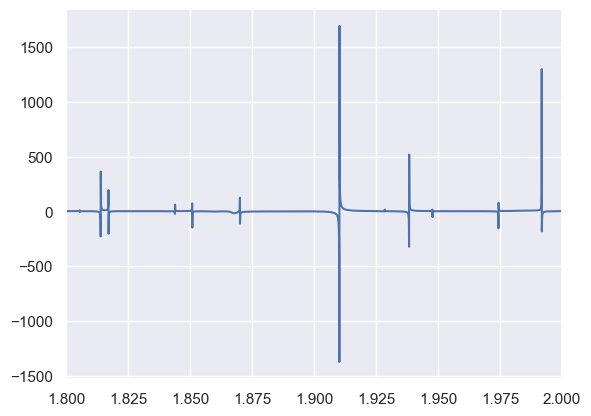

In [46]:
# plotting periodogram
# ------
plt.plot(frequency, power)
plt.xlim(1.8, 2.0)
plt.show()